In [1]:
import os
import gc
import numpy as np
from numpy.fft import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pywt 
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Specify size of seismic signal segements and rate of sampling for high-pass filter
SIGNAL_LEN = 150000
SAMPLE_RATE = 4000

In [14]:
seismic_signals = pd.read_csv('D:/NINI data/data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [15]:
seismic_signals.shape

(629145480, 2)

In [17]:
acoustic_data = seismic_signals.acoustic_data
time_to_failure = seismic_signals.time_to_failure
data_len = len(seismic_signals)


In [18]:
signals = []
targets = []

for i in range(data_len//SIGNAL_LEN):
    min_lim = SIGNAL_LEN * i
    max_lim = min([SIGNAL_LEN * (i + 1), data_len])
    
    signals.append(list(acoustic_data[min_lim : max_lim]))
    targets.append(time_to_failure[max_lim])
    
del acoustic_data
del time_to_failure
gc.collect()
    
signals = np.array(signals)
targets = np.array(targets)

In [20]:
targets.shape

(4194,)

In [6]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [7]:
def high_pass_filter(x, low_cutoff=1000, SAMPLE_RATE=SAMPLE_RATE):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

In [9]:
#Wavelet Denoising
def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

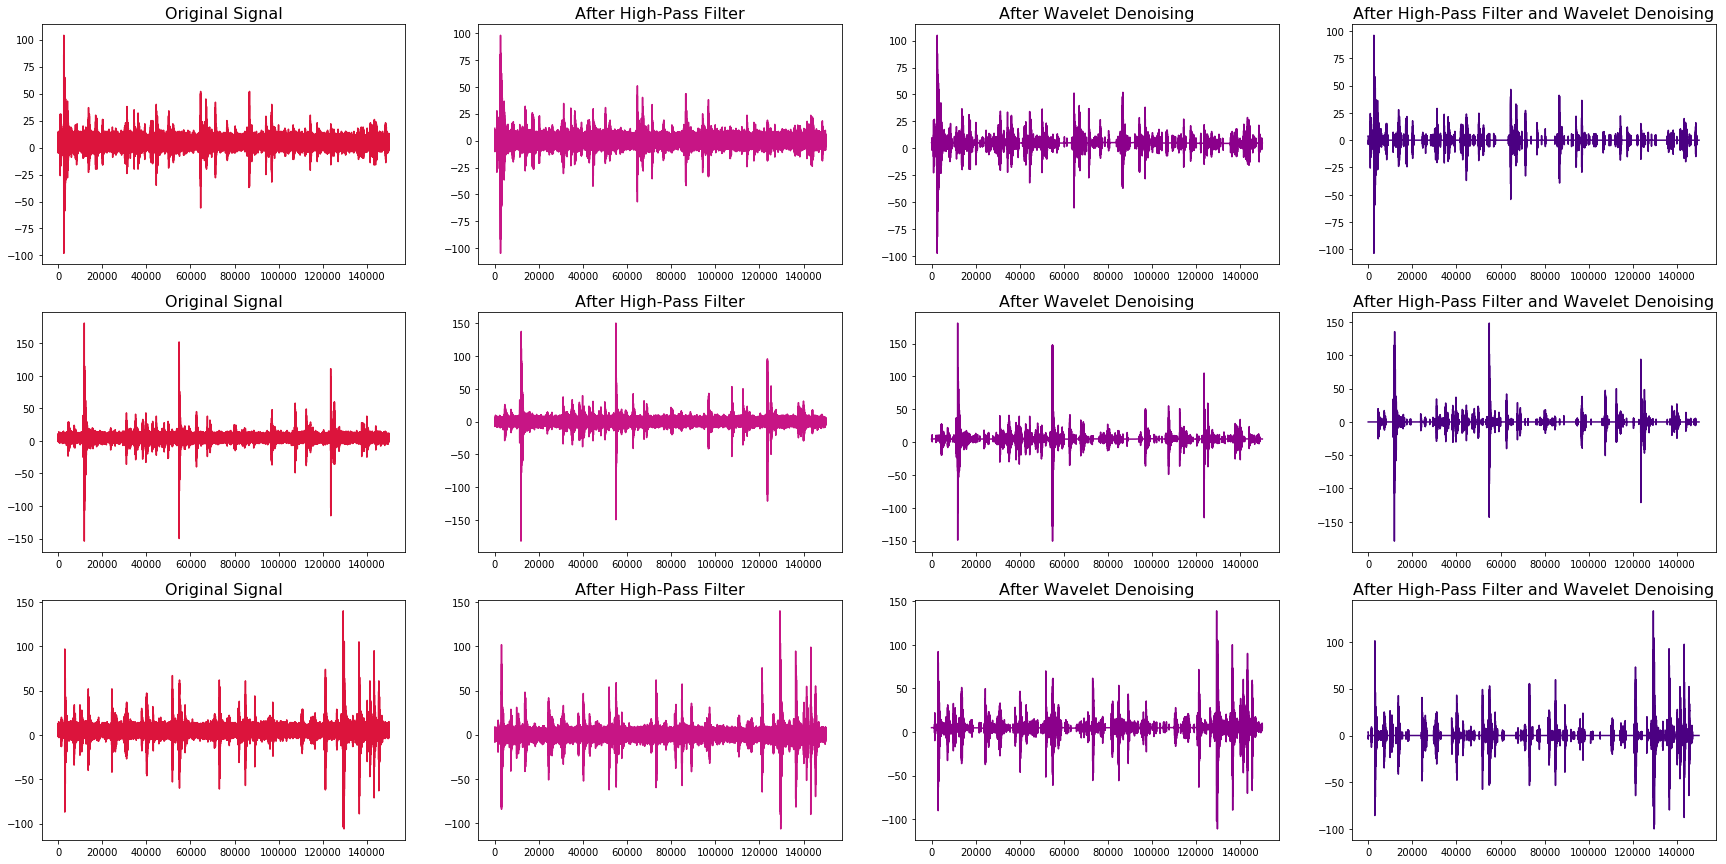

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

ax[0, 0].plot(signals[0], 'crimson') 
ax[0, 0].set_title('Original Signal', fontsize=16)
ax[0, 1].plot(high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000), 'mediumvioletred') 
ax[0, 1].set_title('After High-Pass Filter', fontsize=16)
ax[0, 2].plot(denoise_signal(signals[0]), 'darkmagenta')
ax[0, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[0, 3].plot(denoise_signal(high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), 'indigo')
ax[0, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

ax[1, 0].plot(signals[1], 'crimson') 
ax[1, 0].set_title('Original Signal', fontsize=16)
ax[1, 1].plot(high_pass_filter(signals[1], low_cutoff=10000, SAMPLE_RATE=4000000), 'mediumvioletred') 
ax[1, 1].set_title('After High-Pass Filter', fontsize=16)
ax[1, 2].plot(denoise_signal(signals[1]), 'darkmagenta')
ax[1, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[1, 3].plot(denoise_signal(high_pass_filter(signals[1], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), 'indigo')
ax[1, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

ax[2, 0].plot(signals[2], 'crimson') 
ax[2, 0].set_title('Original Signal', fontsize=16)
ax[2, 1].plot(high_pass_filter(signals[2], low_cutoff=10000, SAMPLE_RATE=4000000), 'mediumvioletred') 
ax[2, 1].set_title('After High-Pass Filter', fontsize=16)
ax[2, 2].plot(denoise_signal(signals[2]), 'darkmagenta')
ax[2, 2].set_title('After Wavelet Denoising', fontsize=16)
ax[2, 3].plot(denoise_signal(high_pass_filter(signals[2], low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1), 'indigo')
ax[2, 3].set_title('After High-Pass Filter and Wavelet Denoising', fontsize=16)

plt.show()

In [ ]:
high_pass_filter(signals, low_cutoff=10000, SAMPLE_RATE=4000000)

In [12]:
signals.shape

(4194, 150000)

In [26]:
new=high_pass_filter(signals[0], low_cutoff=10000, SAMPLE_RATE=4000000)

In [27]:
new.shape

(150000,)